# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [3]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/cmdb/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/rdfs/10.5281/zenodo.6200999/7690494/rdf.yaml. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/rdfs/10.5281/zenodo.6200999/7690494/rdf.yaml.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:442: CacheWarning: Reached cache warnings limit. No more warnings about cache hits will be issued.
  warnings.warn(
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'modality': ['electron-microscopy', 'cryo-electron-microscopy', 'fluorescence-light-microscop

### 1b. Create Prediction Pipelines

In [4]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [5]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [6]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [7]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [9]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [10]:
hpa = hpa_cyto

### 2b. Load Images

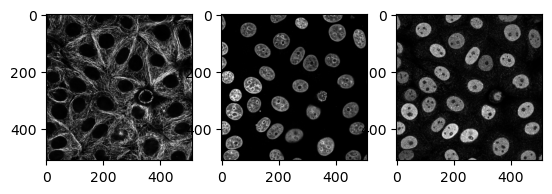

In [53]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [54]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


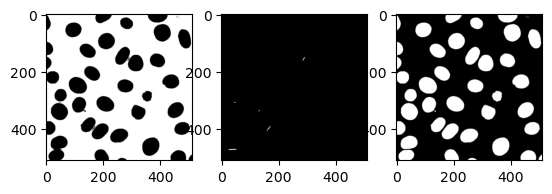

In [55]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [56]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [57]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

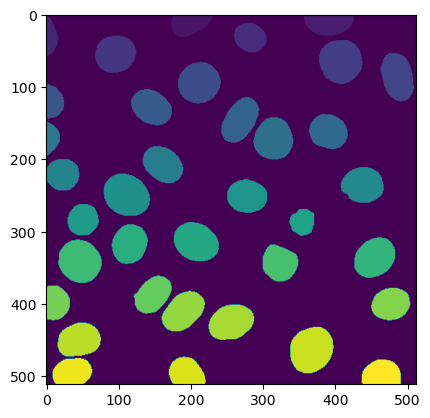

In [58]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [59]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


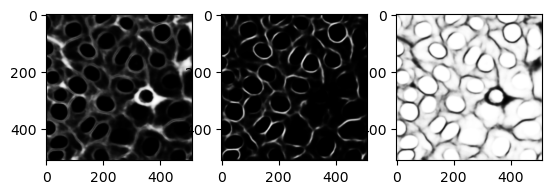

In [60]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

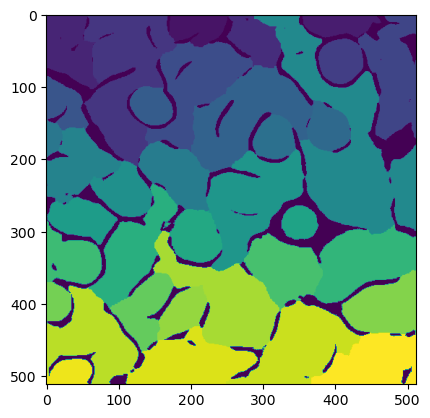

In [61]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [62]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [63]:
sizes

array([27269,  2846,  2724,  5341,  3694, 15393,  3051,  8741, 10135,
        2798,  2461, 12706,  3082,  2781,   871,  5929,  6160, 24570,
        4116, 12238,  3899,  1876,  4105,  8281,  9793,  4449,  6958,
        4771,  1603,  6366,  3188, 12028,  9272, 10779,  8684,  1846,
        7340])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

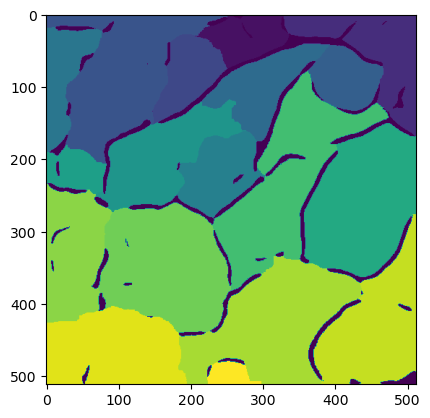

In [22]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [23]:
hpa = hpa_cyto

# Question 2A

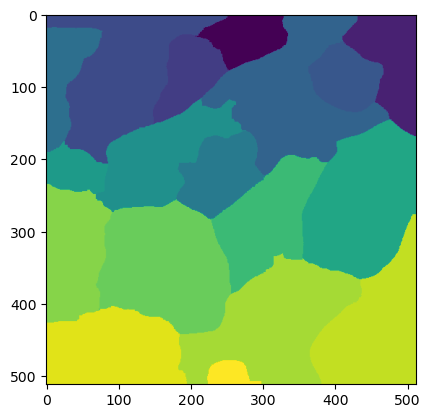

In [24]:
cell_seg = watershed(bd, markers=nuclei)

plt.subplots()
plt.imshow(cell_seg)

- You lose the defined borders between cells, although the image stays pretty good for the most part.

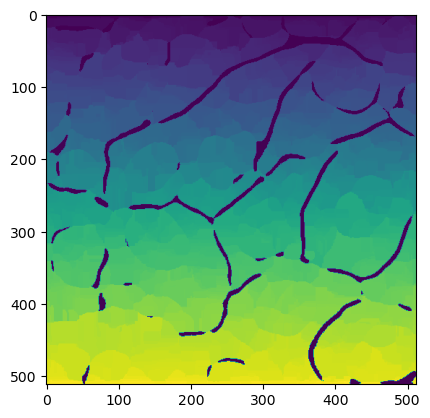

In [25]:
cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

- This image is much worse. You keep some of the cell borders but lose the color-coded fill for each cell, making their boundaries very hard to distinguish.

# Question 2B

In [26]:
hpa = hpa_endo

- Run from part 2B onward

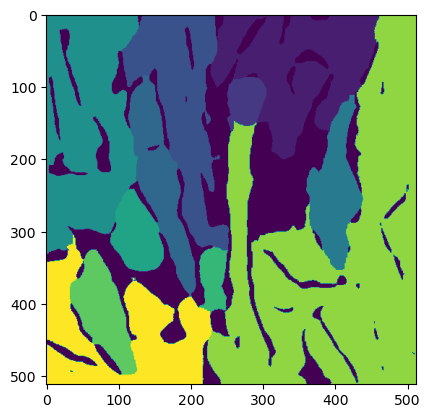

In [38]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

- It seems like it is harder to define cell boundaries based on this image set. There are clearly many faulty boundaries here. Many cells blend into one.

In [39]:
hpa = hpa_mito

- As before, run from 2B onward.

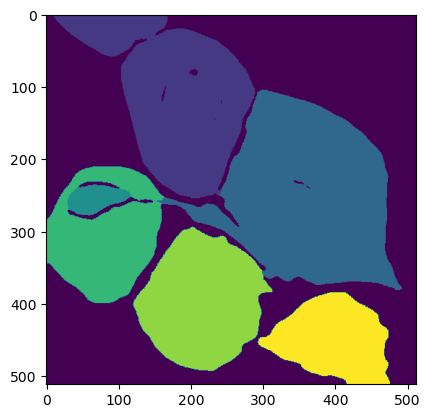

In [51]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

- This image set seems to work pretty well. The borders of the cells are well defined.

In [52]:
hpa = hpa_nucl

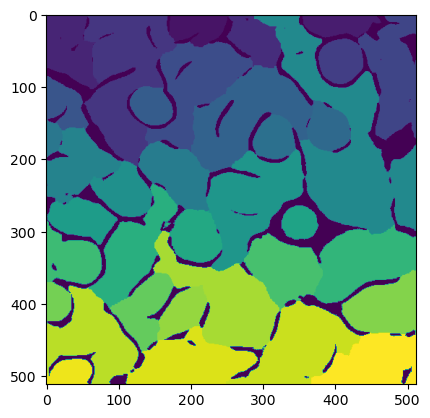

In [64]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

- This image set isn't great but it isn't terrible. Some cells are outlined well while others are blended together.